# A/B Testing Project 

##### Dataset - https://www.kaggle.com/datasets/zhangluyuan/ab-testing/code?select=ab_data.csv

##### Reference Course - https://www.udacity.com/course/ab-testing--ud257

#### Disclaimer - This is just to showcase some skill, the dataset needs more features to make better explainable conclusions. 

### 1. Experiment Introduction and Hypothesis Testing

#### The aim is to formulate and test the hypothesis for comparing the conversion rate between Old web page vs New web page.

#### Two Tailed test:

$H_{0}: p = p_{0}$

$H_{\alpha}: p \neq p_{0}$

#### At confidence interval of 95% - $\alpha = 0.05$




### 2. Data and Preprocessing

In [1]:
import pandas as pd
import numpy as np

#### Import Data

In [2]:
df = pd.read_csv('ab_data.csv')


#### Independent Variables: -
#### Control Group is shown Old web page.
#### Treatment Group is shown New web page.

#### Dependent Variable: - 
#### Converted (0 or 1) represents a buy or click. 

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.shape


(294478, 5)

#### Check for null values and data type

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


#### Data Description

In [6]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [7]:
pd.crosstab(df['group'], df['landing_page'])


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [8]:
df.converted.mean()

0.11965919355605512

#### Check for duplicate user_id

In [9]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


#### Remove duplicate user_id

In [10]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


#### Re-check for duplicate user_id

In [11]:
df[df.user_id.duplicated(keep=False)]


,user_id,timestamp,group,landing_page,converted


#### Assumptions to calculate sample size: -

#### Lets Assume the baseline conversion rate is 11% based on the past data and through the experiment the organization is aiming for 14% conversation rate. 

#### The function sms.proportion_effectsize(0.11, 0.14) is calculating the effect size based on a proportion for two independent samples, in this case with proportions of 0.11 and 0.14.

#### The function sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1) is used to calculate the sample size required for the study. Here power=0.8 and alpha=0.05 are the statistical power and significance level used for the calculation, respectively, and ratio=1 indicates that the sample sizes for the two groups are equal.

#### In the context of hypothesis testing in statistics, power is the probability that a test correctly rejects the null hypothesis when the alternative hypothesis is true. The power of a statistical test is generally defined as 1 - β, where β is the probability of Type II error.

#### Type II error occurs when the null hypothesis is false, but we fail to reject it. So, the power of a test is essentially the test's ability to detect an effect if there is one.

#### Finally, required_n = ceil(required_n) rounds up the number to ensure it is a whole number, since we can't have a fraction of a sample.

In [12]:
import statsmodels.stats.api as sms
from math import ceil

effect_size = sms.proportion_effectsize(0.11, 0.14)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

1902


#### Sample Collection from both Control Group and Treatment Group

In [13]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [14]:
ab_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3804 entries, 0 to 3803
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       3804 non-null   int64 
 1   timestamp     3804 non-null   object
 2   group         3804 non-null   object
 3   landing_page  3804 non-null   object
 4   converted     3804 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 148.7+ KB


In [15]:
ab_test['group'].value_counts()


control      1902
treatment    1902
Name: group, dtype: int64

#### Mean and Standard Deviation of Control Group and Treatment Group

In [16]:
import scipy.stats as stats

conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.124,0.329,0.008
treatment,0.118,0.323,0.007


#### The Mean and Standard Deviation of Control Group and Treatment Group are fairly close indicating not much of significance difference between groups even before test.

### 3. Plot of Connversion for Control Group and Treatment Group

C:\Users\achal\AppData\Local\Temp\ipykernel_10568\3362076549.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)


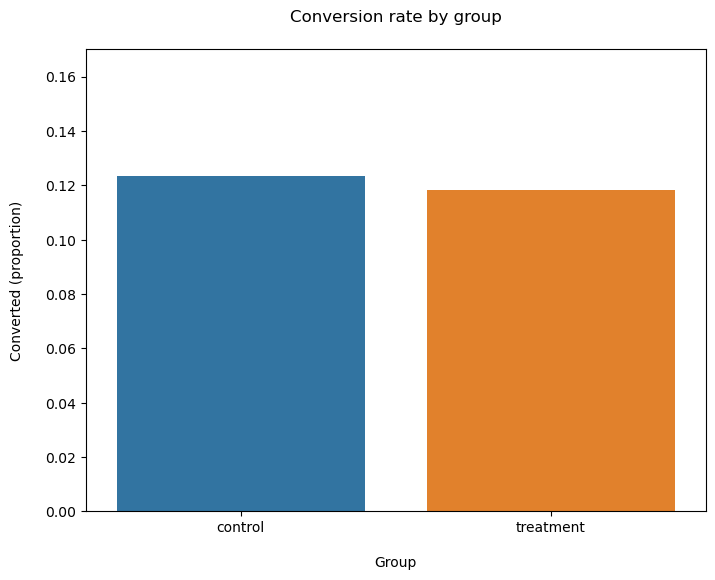

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### 4. Testing the Hypothesis: -

#### The goal is to determine if the proportion of successes (conversions) is significantly different between the two groups. The test statistic is a Z-score (Z-stat).

#### The two-proportion Z-test is used when you have two samples and you want to see if the success rates are significantly different from each other. 

#### At other times, a binomial test may be used when you have one sample and you want to compare the observed success rate to a hypothesized success rate.

In [18]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.50
p-value: 0.619
ci 95% for control group: [0.109, 0.138]
ci 95% for treatment group: [0.104, 0.133]


### 5. Conclusions: -

#### For a two-tailed test at a 95% confidence level (significance level of α = 0.05), the critical Z values are approximately -1.96 and +1.96. suggesting that the result is not statistically significant at the 95% confidence level and fails to reject the null hypothesis.

#### The p-value of 0.619 > 0.05 and thus, insignificant to reject null hypothesis $H_{0}$.

#### The confidence values of treatment group are not approaching to 14% aim expectation.

#### The confidence values of treatment group does not show increment compared to control group instead has only slightly decreased.




## Thank you